In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall, calc_f1_score
import gc
from tqdm import tqdm_notebook
from functools import reduce
import pickle

## Loading data

In [2]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)
train_clean = get_clean_data(train)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)
test['label_true'] = get_labels(test, labels_type='true')

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 34s, sys: 9.76 s, total: 1min 44s
Wall time: 1min 44s


## Results

In [3]:
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'decision_function', 
            'label_predict', 'label_true']

merge_on = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']


df_xgb_7 = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgboost_7.csv', parse_dates=True,
                    usecols=col_list, dtype={'label_predict': int})

df_xgb_n7 = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgboost_noisy_7.csv', parse_dates=True,
                  usecols=col_list, dtype={'label_predict': int})

df_xgb_air = pd.read_csv('/mnt/HARD/MinMax94/models/results/xgboost_air_4.csv', parse_dates=True,
                    usecols=col_list, dtype={'label_predict': int})

df_ridge_7 = pd.read_csv('/mnt/HARD/MinMax94/models/results/ridge_7.csv', parse_dates=True,
                    usecols=col_list, dtype={'label_predict': int})

df_ridge_n7 = pd.read_csv('/mnt/HARD/MinMax94/models/results/ridge_noisy_7.csv', parse_dates=True,
                    usecols=col_list, dtype={'label_predict': int})


df_ee = pd.read_csv('/mnt/HARD/MinMax94/models/results/elliptic_envelope.csv', parse_dates=True,
                  usecols=col_list, dtype={'label_predict': int})

df_svm = pd.read_csv('/mnt/HARD/MinMax94/models/results/one_class_svm_005.csv', parse_dates=True,
                  usecols=col_list, dtype={'label_predict': int})

df_lof = pd.read_csv('/mnt/HARD/MinMax94/models/results/local_outlier_factor.csv', parse_dates=True,
                      usecols=[col for col in col_list if col!='decision_function'], 
                      dtype={'label_predict': int})

df_iforest = pd.read_csv('/mnt/HARD/MinMax94/models/results/isolation_forest.csv', parse_dates=True,
                  usecols=col_list, dtype={'label_predict': int})

df_list = [(df_xgb_7, 'xgb_7'), (df_xgb_n7, 'xgb_n7'), (df_xgb_air, 'xgb_air'),
           (df_ridge_7, 'ridge_7'), (df_ridge_n7, 'ridge_n7'),
           (df_ee, 'ee'), (df_svm, 'svm'), (df_lof, 'lof'), (df_iforest, 'iforest')]

for df, name in df_list:
    df['label_predict_{0}'.format(name)] = df['label_predict']
    del df['label_predict']
    
    if name != 'lof':
        df['decision_function_{0}'.format(name)] = df['decision_function']
        del df['decision_function']
    
    elif name == 'lof':
        df['decision_function_{0}'.format(name)] = df['label_predict_lof']
        
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']

        
df_test = pd.merge(df_xgb_7, df_xgb_n7, on=merge_on)
df_test = pd.merge(df_test, df_xgb_air, on=merge_on)
df_test = pd.merge(df_test, df_ridge_7, on=merge_on)
df_test = pd.merge(df_test, df_ridge_n7, on=merge_on)
df_test = pd.merge(df_test, df_ee, on=merge_on)
df_test = pd.merge(df_test, df_svm, on=merge_on)
df_test = pd.merge(df_test, df_lof, on=merge_on)
df_test = pd.merge(df_test, df_iforest, on=merge_on)

df_test['date_time_utc'] = pd.to_datetime(df_test['date_time_utc'])

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_test['decision_function_xgb_7'] = scaler.fit_transform(df_test['decision_function_xgb_7'].values.reshape(-1, 1))
pickle.dump(scaler, open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('xgb_7'), 'wb'))

df_test['decision_function_xgb_n7'] = scaler.fit_transform(df_test['decision_function_xgb_n7'].values.reshape(-1, 1))
pickle.dump(scaler, open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('xgb_n7'), 'wb'))

df_test['decision_function_xgb_air'] = scaler.fit_transform(df_test['decision_function_xgb_air'].values.reshape(-1, 1))
pickle.dump(scaler, open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('xgb_air'), 'wb'))

df_test['decision_function_ridge_7'] = scaler.fit_transform(df_test['decision_function_ridge_7'].values.reshape(-1, 1))
pickle.dump(scaler, open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('ridge_7'), 'wb'))

df_test['decision_function_ee'] = scaler.fit_transform(-df_test['decision_function_ee'].values.reshape(-1, 1))
pickle.dump(scaler, open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('ee'), 'wb'))

df_test['decision_function_svm'] = scaler.fit_transform(-df_test['decision_function_svm'].values.reshape(-1, 1))
pickle.dump(scaler, open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('svm'), 'wb'))

df_test['decision_function_lof'] = df_test['decision_function_lof']
#pickle.dump(scaler, open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('lof'), 'wb'))

df_test['decision_function_iforest'] = scaler.fit_transform(-df_test['decision_function_iforest'].values.reshape(-1, 1))
pickle.dump(scaler, open('/mnt/HARD/MinMax94/models/scalers/mm_{0}.pickle'.format('iforest'), 'wb'))

In [5]:
z = df_test[['decision_function_xgb_7', 'decision_function_xgb_n7', 
             'decision_function_ridge_7', 'decision_function_ridge_n7',
             'decision_function_xgb_air',
             'decision_function_ee',
             'decision_function_svm', 'decision_function_lof', 
             'decision_function_iforest', 'label_true']]
z.corr()

,decision_function_xgb_7,decision_function_xgb_n7,decision_function_ridge_7,decision_function_ridge_n7,decision_function_xgb_air,decision_function_ee,decision_function_svm,decision_function_lof,decision_function_iforest,label_true
decision_function_xgb_7,1.000000,0.860369,0.820236,0.813420,0.288925,0.730726,0.368647,0.280171,0.168986,0.148027
decision_function_xgb_n7,0.860369,1.000000,0.881904,0.869087,0.233513,0.782925,0.369306,0.275569,0.187359,0.122508
decision_function_ridge_7,0.820236,0.881904,1.000000,0.967366,0.222178,0.841171,0.384880,0.277296,0.182559,0.132806
decision_function_ridge_n7,0.813420,0.869087,0.967366,1.000000,0.225174,0.825499,0.385755,0.275126,0.220826,0.121879
decision_function_xgb_air,0.288925,0.233513,0.222178,0.225174,1.000000,0.272387,0.151643,0.079544,0.170959,0.131608
decision_function_ee,0.730726,0.782925,0.841171,0.825499,0.272387,1.000000,0.499425,0.209143,0.386157,0.102241
decision_function_svm,0.368647,0.369306,0.384880,0.385755,0.151643,0.499425,1.000000,0.235813,0.502852,0.144206
decision_function_lof,0.280171,0.275569,0.277296,0.275126,0.079544,0.209143,0.235813,1.000000,0.037503,0.129832
decision_function_iforest,0.168986,0.187359,0.182559,0.220826,0.170959,0.386157,0.502852,0.037503,1.000000,0.014847
label_true,0.148027,0.122508,0.132806,0.121879,0.131608,0.102241,0.144206,0.129832,0.014847,1.000000


In [6]:
df_test['label_predict'] = ((0.148027 * df_test['decision_function_xgb_7'] +
                             0.122509 * df_test['decision_function_xgb_n7'] + 
                            0.132806 * df_test['decision_function_ridge_7'] +
                            0.121879 * df_test['decision_function_ridge_n7'] +
                            0.131608 * df_test['decision_function_xgb_air'] +
                            0.102241 * df_test['decision_function_ee'] + 
                            0.144206 * df_test['decision_function_svm'] +
                            0.124231 * df_test['decision_function_lof'] + 
                            0.008724 * df_test['decision_function_iforest']) /
                            (0.148027 + 0.122509+ 0.132806 + 0.121879 + 0.131608 + 0.102241 + 0.144206 + 0.124231 + 0.008724)) >= 0.19

In [7]:
df_test['label_predict'] = ((0.148027 * df_test['decision_function_xgb_7'] +
                             0.122509 * df_test['decision_function_xgb_n7'] + 
                            0.132806 * df_test['decision_function_ridge_7'] +
                            0.131608 * df_test['decision_function_xgb_air'] +
                            0.108682 * df_test['decision_function_ee'] +
                            0.135192 * df_test['decision_function_svm'] +
                            0.008721 * df_test['decision_function_iforest']) /
                            (0.148027 + 0.122509 + 0.132806 + 0.131608 + 0.108682 + 0.135192 + 0.008721)) >= 0.23

In [289]:
df_test['label_predict'] = ((0.432 * df_test['decision_function_xgb_7'] +
                            #0.469 * df_test['decision_function_xgb_n7'] + 
                            #0.609 * df_test['decision_function_ridge_7'] +
                            0.488 * df_test['decision_function_xgb_air'] +
                            #0.6681 * df_test['decision_function_ee'] +
                            0.719 * df_test['decision_function_svm'] + 
                            0.008 * df_test['decision_function_iforest']) /
                            (0.432 + 0.488 + 0.719 + 0.008)) >= 0.29

In [16]:
df_test['label_predict'] = (((1.0 * df_test['decision_function_xgb_7'] +
                             1.0 * df_test['decision_function_xgb_n7'] + 
                             1.0 * df_test['decision_function_xgb_air'] +
                             1.0 * df_test['decision_function_ridge_7'] +
                             1.0 * df_test['decision_function_ee'] +
                             1.0 * df_test['decision_function_svm'] +
                             1.0 * df_test['decision_function_lof'] +
                             1.0 * df_test['decision_function_iforest']) / 8.0) >= 0.27)

In [ ]:
df_test['label_predict'] = (((0.557463 * df_test['decision_function_xgb_7'] +
                             0.568428 * df_test['decision_function_xgb_n7'] + 
                             0.523619 * df_test['decision_function_xgb_air'] +
                             0.518895 * df_test['decision_function_ridge_7'] +
                             0.565429 * df_test['decision_function_ee'] +
                             0.678251 * df_test['decision_function_svm'] +
                             0.049970 * df_test['decision_function_lof'] +
                             0.195507 * df_test['decision_function_iforest']) / 
                             (0.557463 + 0.568428 + 0.523619 + 0.518895 + 
                              0.565429 + 0.678251 + 0.049970 + 0.195507)) >= thresh)

In [14]:
window = pd.Timedelta('4h')
st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]

df_test['label_predict'] = df_test['label_predict_iforest']
recall = calc_recall(df_test, st_id, window)
precision = calc_precision(df_test, st_id, window)
f1_score = calc_f1_score(precision, recall)

print("Recall: {0:.3f} \nPrecision: {1:.3f} \nF1:{2:.3f}".format(recall, precision, f1_score))
print("----------------------------------------")

Recall: 0.362 
Precision: 0.233 
F1:0.283
----------------------------------------


## Result

In [8]:
window = pd.Timedelta('4h')
st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
thresh_list = []
#st_id = [114, 117, 119, 302, 303, 442, 503, 504, 511, 1838, 1896]
#st_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

for thresh in np.arange(0.15, 0.40, 0.01):
    df_test['label_predict'] = (((1.0 * df_test['decision_function_xgb_7'] +
                             1.0 * df_test['decision_function_xgb_n7'] + 
                             1.0 * df_test['decision_function_xgb_air'] +
                             1.0 * df_test['decision_function_ridge_7'] +
                             1.0 * df_test['decision_function_ee'] +
                             1.0 * df_test['decision_function_svm'] +
                             1.0 * df_test['decision_function_lof'] +
                             1.0 * df_test['decision_function_iforest']) / 8.0) >= thresh)
    recall = calc_recall(df_test, st_id, window)
    precision = calc_precision(df_test, st_id, window)
    f1_score = calc_f1_score(precision, recall)
    thresh_list.append({'Threshold': thresh, 'Recall': recall, 'Precision': precision, 'F1': f1_score})
    
    print("Threshhold: {0:.2f}".format(thresh))
    print("Recall: {0:.3f} \nPrecision: {1:.3f} \nF1:{2:.3f}".format(recall, precision, f1_score))
    print("----------------------------------------")

Threshhold: 0.15
Recall: 0.798 
Precision: 0.323 
F1:0.460
----------------------------------------
Threshhold: 0.16
Recall: 0.770 
Precision: 0.401 
F1:0.527
----------------------------------------
Threshhold: 0.17
Recall: 0.755 
Precision: 0.461 
F1:0.572
----------------------------------------
Threshhold: 0.18
Recall: 0.755 
Precision: 0.505 
F1:0.605
----------------------------------------
Threshhold: 0.19
Recall: 0.753 
Precision: 0.538 
F1:0.628
----------------------------------------
Threshhold: 0.20
Recall: 0.753 
Precision: 0.576 
F1:0.653
----------------------------------------
Threshhold: 0.21
Recall: 0.743 
Precision: 0.609 
F1:0.669
----------------------------------------
Threshhold: 0.22
Recall: 0.743 
Precision: 0.639 
F1:0.687
----------------------------------------
Threshhold: 0.23
Recall: 0.740 
Precision: 0.658 
F1:0.696
----------------------------------------
Threshhold: 0.24
Recall: 0.710 
Precision: 0.669 
F1:0.689
----------------------------------------


## Cycle

In [86]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')
station_list = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

for station_id in station_list:
    st_id = [station_id]
    for station in st_id:
        df = df_test[df_test['station_id']==station]
        predicted_anomalies = df[df['label_predict']==1]
        for anomaly in predicted_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            predicted_anomalies_ids.update(set(locality.index))

    true_anomalies_ids = set(df_test[(df_test['label_true']==1) & (df_test['station_id'].isin(st_id))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    recall = len(tp) / len(true_anomalies_ids)

    true_anomalies_ids = set()
    window = pd.Timedelta('4h')

    for station in st_id:
        df = df_test[df_test['station_id']==station]
        true_anomalies = df[df['label_true']==1]
        for anomaly in true_anomalies.iterrows():
            dt = anomaly[1]['date_time_utc']
            locality = df_test[(df_test['date_time_utc'] >= (dt - window)) & 
                           (df_test['date_time_utc'] <= (dt + window))]

            true_anomalies_ids.update(set(locality.index))
            # print(list(locality.index))

    predicted_anomalies_ids = set(df_test[((df_test['label_predict']==1) & (df_test['station_id'].isin(st_id)))].index)

    tp = set.intersection(true_anomalies_ids, predicted_anomalies_ids)
    precision = len(tp) / len(predicted_anomalies_ids)
    
    print('{0} : R = {1:0.3f}, P = {2:0.3f}'.format(station_id, recall, precision))

114 : R = 0.611, P = 0.286
117 : R = 0.546, P = 0.685
119 : R = 0.818, P = 0.385
302 : R = 0.644, P = 0.605
303 : R = 0.628, P = 0.444
307 : R = 0.181, P = 0.954
393 : R = 0.039, P = 0.424
442 : R = 1.000, P = 0.541
503 : R = 0.137, P = 0.375
504 : R = 1.000, P = 0.545
511 : R = 1.000, P = 0.657
516 : R = 0.310, P = 0.552
1838 : R = 0.903, P = 0.565
1896 : R = 0.678, P = 0.904


## Plot

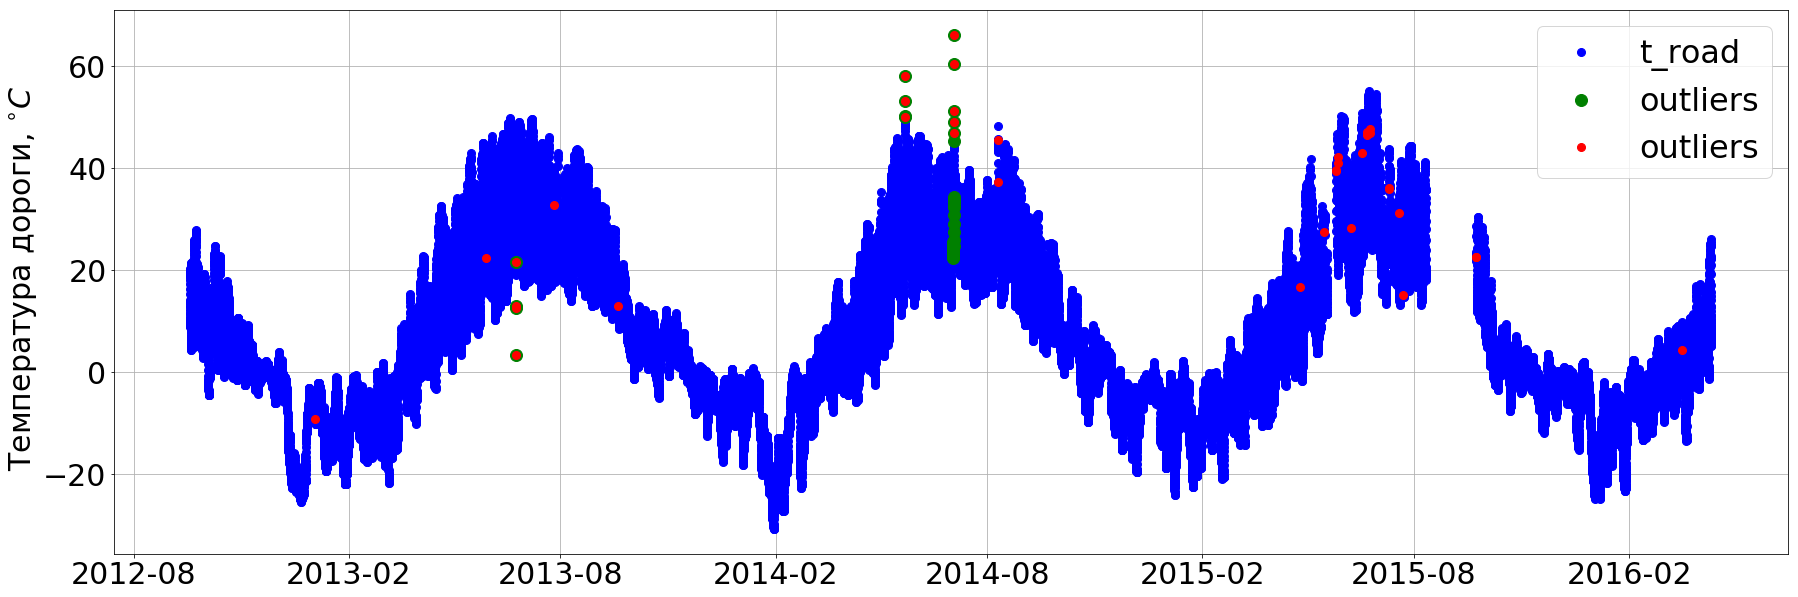

In [101]:
import matplotlib.pyplot as plt

#st_id = [114, 117, 119, 442, 504, 511, 1838, 1896]
#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 119, 302, 303, 442, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==114].set_index('date_time_utc'))

start = pd.Timestamp(2012, 7, 5)
end = pd.Timestamp(2017, 7, 20)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()